In [ ]:
from dotenv import load_dotenv
load_dotenv()

In [4]:
import logging
# Set up the logger
logging.basicConfig(
    level=logging.INFO,  # Set to DEBUG for detailed logs
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        # logging.FileHandler("scraper.log"),  # Log to a file
        logging.StreamHandler()  # Log to console
    ]
)

logger = logging.getLogger(__name__)

In [ ]:
from bs4 import BeautifulSoup
import html2text
import httpx


def fetch_documents(url: str) -> str:
    """Fetch a document from a URL and return the markdownified text.

    Args:
        url (satr): The URL of the document to fetch.

    Returns:
        str: The markdownified text of the document.
    """
    httpx_client = httpx.Client(follow_redirects=True, timeout=10)

    try:
        response = httpx_client.get(url, timeout=10)
        response.raise_for_status()
        html_content = response
        soup = BeautifulSoup(html_content, 'html.parser')
        a_tags = soup.find_all('a')
        for a_tag in a_tags:
            a_tag.decompose()
        
        img_tags = soup.find_all('img')
        for img_tag in img_tags:
            img_tag.decompose()

        target_div = soup.find('div', class_= "theme-doc-markdown markdown") #langchain
        
        if not target_div:
            target_div = soup.find('article') #langraph
        
        if not target_div:
            return
        
        return html2text.html2text(str(target_div))
    except (httpx.HTTPStatusError, httpx.RequestError) as e:
        return f"Encountered an HTTP error: {str(e)}"

In [ ]:
from pprint import pprint
pprint(fetch_documents("https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams"))

In [1]:
# list of agent architectures
agent_architecture_urls = ["https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration",
 "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor",
 "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams",
 "https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute",
 "https://langchain-ai.github.io/langgraph/tutorials/self-discover/self-discover",
 "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams"
]

# "https://langchain-ai.github.io/langgraph/concepts/agentic_concepts",
# "https://langchain-ai.github.io/langgraph/concepts/multi_agent"
# "https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo",
# "https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler",
# "https://langchain-ai.github.io/langgraph/tutorials/reflection/reflection",
# "https://langchain-ai.github.io/langgraph/tutorials/reflexion/reflexion",
# "https://langchain-ai.github.io/langgraph/tutorials/lats/lats",

In [ ]:
# TODO first subagent to create from https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/

# TODO critical thinking to allow for model suggestions

from pydantic import Field, BaseModel
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from typing import List
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from pprint import pprint
from models.agent_architecture import AgentArchitecture
from langgraph.types import Send
import operator
from typing import Annotated
from typing import NamedTuple


template = """Your job is to get information from a user about what kind of agent they wish to build.

You should get the following information from them:

- What the objective of the agent is
- Various responsibilities of the agent 

- What model provider to use

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the tool AgentInstruction """

class AgentInstructions(BaseModel):
    """Instructions on how to build the Agent"""
    objective: str = Field(description= "What is the primary objective of the agent")
    responsibilities: List[str] = Field(description= "What are the various responsibilities of the agent which it needs to fulfill")
    model_provider : str = Field(description= "Which model provider powers the LLM workload? eg. OpenAI/Claude/CodeLLama etc.")

class ArchEvaluationReport(BaseModel):
    """Class to represent the architecture evaluation report"""
    name: str = Field(description="Name of the agent architecture being evaluated")
    highlights: str = Field(description="Concise summary of the architecture in 5 lines")
    evaluation_score: int = Field(description="evaluation of suitability of the agentic_architecture against user requirements from 1-10, 1 being least relevant to 10 being most relevant")
    justification: str = Field( description="Justification for the score")
    tailored_design: str = Field(description="Tailored design using the architecture")
    
class ArchEvaluationWithUrl(NamedTuple):
    url: str
    report: ArchEvaluationReport

class AgentBuilderState(MessagesState):
    agent_instructions: AgentInstructions = Field("the requirement analysis generated by the model.")
    arch_evaluation_reports: Annotated[List[ArchEvaluationWithUrl], operator.add] = Field("list of agent architectures suggested in map-reduce step")
    best_agent_architecture: ArchEvaluationWithUrl = Field("The agent architecture best suited to above requirements")
    yaml_code: str = Field("The YAML code generated")
    python_code: str = Field("The Python code generated")

class ArchitectureEvaluationState(MessagesState):
    agent_instructions: AgentInstructions = Field("the requirement analysis generated by the model.")
    url: str = Field("url of the agent architecture to evaluate against")

llm = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

def requirement_analysis_node(state: AgentBuilderState):
    
    llm_with_tool = llm.bind_tools([AgentInstructions])
    response = llm_with_tool.invoke([SystemMessage(content=template)] + state["messages"])
    
      # Construct the final answer from the arguments of the last tool call  
    if len(response.tool_calls) == 0:
        return {"messages": [response]}
    
    agent_instructions = response.tool_calls[0]
    agent_instructions = AgentInstructions(**agent_instructions["args"])
    
    return {"messages": [response], "agent_instructions": agent_instructions}

ARCH_EVALUATION_PROMPT = PromptTemplate.from_template(
    """
You are tasked with assessing the provided agentic architecture documentation to determine its relevance and applicability to the user requirements outlined below.

Agentic Architecture Documentation:

{agent_architecture}

User Requirements:

Objectives: {objective}

Responsibilities: {responsibilities}

Deliverables: 

Provide your evaluation in the following structured format:

1. Name of the Agent Architecture

2. A concise name for the architecture being evaluated.

3. 2-3 Line Highlights about the Architecture

4. Summarize the key features and unique aspects of the architecture.

5. Relevance Score (1-10) : Provide a numerical score (1 being not relevant, 10 being highly relevant) based on the alignment between the architecture and the user requirements.

6. Justification for the Score: A brief rationale (5-10 lines) explaining why you gave this score, citing specific features or misalignments with the user requirements.

7. Tailored Design Using the Architecture for the User Requirements: Propose an implementation of the architecture that aligns with the user’s objectives and responsibilities. Be precise and action-focused in detailing how it can meet their needs.
"""
)

def architecture_evaluation_map_node(state: AgentBuilderState):
    return [Send("evaluate_against_architecture", {"agent_instructions": state["agent_instructions"], "url": url}) for url in agent_architecture_urls]

def route_state(state: AgentBuilderState):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "requirement_analysis"

def evaluate_against_architecture(state: ArchitectureEvaluationState):
    agent_instructions: AgentInstructions = state["agent_instructions"]
    url: str = state["url"]
    llm_with_structured_output = llm.with_structured_output(ArchEvaluationReport)
    archEvaluationReport: ArchEvaluationReport = llm_with_structured_output.invoke(
        [SystemMessage(content=ARCH_EVALUATION_PROMPT.format(agent_architecture=fetch_documents(url),
                                                             objective=agent_instructions.objective,
                                                             responsibilities=agent_instructions.responsibilities))])
    
    return {
        "messages": [AIMessage(content=f"Evaluated architecture {url}, arch_name: {archEvaluationReport.name}")],
        "arch_evaluation_reports": [ArchEvaluationWithUrl(url,archEvaluationReport)],
    }

def best_architecture(state: AgentBuilderState):
    """Select the best architecture based on the evaluation reports."""
    # Sort the architectures based on their evaluation scores
    arch_reports : List[ArchEvaluationWithUrl] = state["arch_evaluation_reports"]
    sorted_architectures = sorted(arch_reports, key=lambda x: x.report.evaluation_score , reverse=True)
    
    # Select the best architecture (the first one in the sorted list)
    best_architecture = sorted_architectures[0]
    
    print("found the best architecture")
    
    # Return the best architecture as the output
    return {
        "messages": [AIMessage(content="Best architecture selected!")],
        "best_agent_architecture": best_architecture,
    }

AGENT_KERNEL_PROMPT = PromptTemplate.from_template(
    """
        You are tasked with designing a langgraph StateGraph object that implements the {agent_architecture_name} architecture tailored to meet the user requirements outlined below.
        <Requirements>
        Objectives: {objective}
        Responsibilities: {responsibilities}
        </Requirements>

        <Documentation for {agent_architecture_name}>
        {agent_architecture}
        </Documentation for {agent_architecture_name}>
        
        Suggestion on how to implement the architecture in a way that meets the user requirements:
        {agent_tailored}
        
        Output needs to be a compiled StateGraph object.
        
        Important to Note:
        * Do not hallucinate when writing StateGraph related code, refer to the documentation provided.
        * Understand the concept of the architecture, and refer to the examples of code. Now generate your own code tailored to requirements.
    """)

def agent_kernel_builder(state: AgentBuilderState):
    """Build the agent kernel using the best architecture."""
    best_architecture: ArchEvaluationWithUrl = state["best_agent_architecture"]
    agent_instructions : AgentInstructions = state["agent_instructions"]
    langgraph_glossary_url = "https://langchain-ai.github.io/langgraph/concepts/low_level/"
    agent_architecture_url : str = best_architecture.url
    agent_architecture_report : ArchEvaluationReport = best_architecture.report
    # agent_architecture_report.name
    #agent_architecture_report.highlights
    #agent_architecture_report.justification
    #agent_architecture_report.tailored_design
    
    response =  llm.invoke([SystemMessage(content=AGENT_KERNEL_PROMPT.format(
        objective=agent_instructions.objective,
        responsibilities=agent_instructions.responsibilities,
        # langgraph_glossary=fetch_documents(langgraph_glossary_url),
        agent_tailored=agent_architecture_report.tailored_design,
        agent_architecture_name = agent_architecture_report.name,
        agent_architecture=fetch_documents(agent_architecture_url)))])
    
    # Return the generated agent kernel as the output
    return {
        "messages": [AIMessage(content="Generated agent kernel code!")],
        "python_code": response.content,
    }
    

CODE_TO_YAML_PROMPT = PromptTemplate.from_template("""
You are tasked with converting the following stategraph comilation code into a YAML format. The code is as follows:
{code_snippet}

Here is how the YAML schema looks like:
stategraph:
  state:
    overall_state:
      type: TypedDict
      fields:
        foo: str
        user_input: str
        graph_output: str
    input_schema:
      type: TypedDict
      fields:
        user_input: str
    output_schema:
      type: TypedDict
      fields:
        graph_output: str
    private_schema:
      type: TypedDict
      fields:
        bar: str
    config_schema:
      type: TypedDict
      fields:
        llm: str
  nodes:
    - name: node_1
      function: node_1_function
      reducer: default
    - name: node_2
      function: node_2_function
      reducer: add
    - name: node_3
      function: node_3_function
      reducer: default
  edges:
    - from: START
      to: node_1
    - from: node_1
      to: node_2
    - from: node_2
      to: node_3
    - from: node_3
      to: END
  conditional_edges:
    - from: node_1
      routing_function: routing_function_name
      mapping:
        True: node_2
        False: node_3
  messages:
    - type: list
      reducer: add_messages
  command:
    - node: my_node
      update:
        foo: "bar"
      goto: my_other_node
  recursion_limit: 25
  interrupt:
    - node: human_approval_node
      question: "Is it ok to continue?"
  subgraphs:
    - name: subgraph_1
      nodes:
        - name: subgraph_node
          function: subgraph_node_function
      edges:
        - from: subgraph_node
          to: END
""")

def code_to_yaml_node(state: AgentBuilderState):
    """Convert the generated code to YAML."""
    yaml_code_ouptut = llm.invoke([SystemMessage(content=CODE_TO_YAML_PROMPT.format(code_snippet=state["python_code"]))])
    
    # Return the YAML code as the output
    return {
        "messages": [AIMessage(content="Generated YAML code!")],
        "yaml_code": yaml_code_ouptut.content,
    }

memory = MemorySaver()
workflow = StateGraph(AgentBuilderState)
workflow.add_node("requirement_analysis", requirement_analysis_node)
workflow.add_node("evaluate_against_architecture", evaluate_against_architecture)
workflow.add_node("best_architecture", best_architecture)
workflow.add_node("agent_kernel_builder", agent_kernel_builder)
workflow.add_node("code_to_yaml", code_to_yaml_node)

@workflow.add_node
def add_tool_message(state: AgentBuilderState):
    
   
    return {
        "messages": [
            ToolMessage(
                content="Requirements generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }


workflow.add_edge("code_to_yaml", END)
workflow.add_edge("agent_kernel_builder", "code_to_yaml")
workflow.add_edge("best_architecture", "agent_kernel_builder")
workflow.add_edge("evaluate_against_architecture", "best_architecture")
workflow.add_conditional_edges("add_tool_message", architecture_evaluation_map_node,["evaluate_against_architecture"])
workflow.add_conditional_edges("requirement_analysis", route_state, ["add_tool_message", "requirement_analysis", END])
workflow.add_edge(START, "requirement_analysis")
infograph = workflow.compile(checkpointer=memory)

In [ ]:
llm.invoke("what do you know about pregel?")

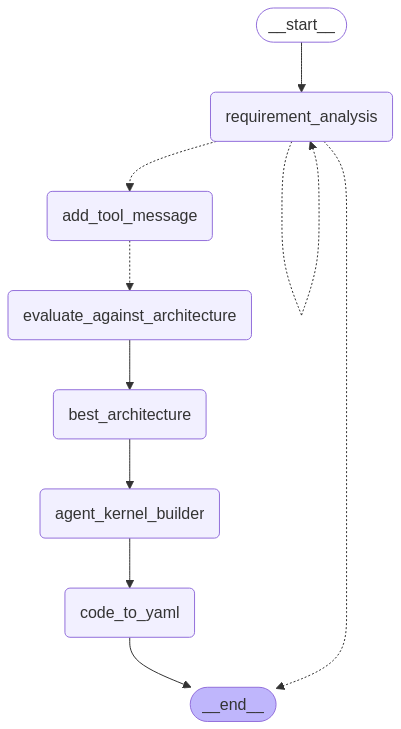

In [11]:
from IPython.display import Image, display
display(Image(infograph.get_graph().draw_mermaid_png()))


In [16]:
# I wish to build a nutritional LLM agent which tracks user goals, allows logging via natural language, provide nutritional and exercise guidance

# 1. lose weight, gain muscle. 2. suggest recipes, provide guidance, track meals, allow meal logging. 3. OpenAi

In [ ]:
# I wish to build an AI fitness coach

# 1. The primary objective is to become a reliable companion/guide to a user on their fitness journeys. Some responsibilities are: 1. If user asks them questions related to diet or exercise, coach answers them based on trustable fact based data, and also tailors the information to the context of the user. 2. The other responsibility is gathering information from the user, i.e. allowing meal logging via NLP 3. The model provider is OpenAI.

In [10]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in infograph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")
        

User (q/Q to quit): I wish to build an AI fitness coach


2025-04-10 23:30:56,007 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Great! To help you build your AI fitness coach, I need a bit more information:

1. What is the primary objective of the agent? (e.g., providing workout plans, nutrition advice, tracking progress, etc.)
2. What are the various responsibilities of the agent? (e.g., creating personalized workout routines, offering dietary suggestions, monitoring user progress, etc.)
3. Which model provider do you want to use for the AI? (e.g., OpenAI, Claude, CodeLLama, etc.)

Please provide these details!
User (q/Q to quit): 1. The primary objective is to become a reliable companion/guide to a user on their fitness journeys. Some responsibilities are: 1. If user asks them questions related to diet or exercise, coach answers them based on trustable fact based data, and also tailors the information to the context of the user. 2. The other responsibility is gathering information from the user, i.e. allowing meal logging via NL

2025-04-10 23:31:09,860 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  AgentInstructions (call_g9YcELgraFImxlypALaHZSSa)
 Call ID: call_g9YcELgraFImxlypALaHZSSa
  Args:
    objective: Become a reliable companion/guide to a user on their fitness journeys.
    responsibilities: ["Answer user questions related to diet or exercise based on trustworthy fact-based data, tailored to the user's context.", 'Gather information from the user, allowing meal logging via NLP.']
    model_provider: OpenAI
================================= Tool Message =================================

Requirements generated!


2025-04-10 23:31:14,506 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams "HTTP/1.1 301 Moved Permanently"
2025-04-10 23:31:14,512 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration "HTTP/1.1 301 Moved Permanently"
2025-04-10 23:31:14,513 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute "HTTP/1.1 301 Moved Permanently"
2025-04-10 23:31:14,514 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/self-discover/self-discover "HTTP/1.1 301 Moved Permanently"
2025-04-10 23:31:14,516 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams "HTTP/1.1 301 Moved Permanently"
2025-04-10 23:31:14,517 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor "HTTP/1.1 301 Moved 

================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams, arch_name: Hierarchical Agent Teams
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor, arch_name: Multi-agent Supervisor Architecture
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute, arch_name: Plan-and-Execute Agent Architecture
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams, arch_name: Hierarchical Agent Teams
================================== Ai Message =======================

2025-04-10 23:31:25,962 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams "HTTP/1.1 301 Moved Permanently"
2025-04-10 23:31:25,977 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/ "HTTP/1.1 200 OK"
2025-04-10 23:31:27,511 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Generated agent kernel code!


2025-04-10 23:31:48,125 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Generated YAML code!
User (q/Q to quit): q
AI: Byebye


https://smith.langchain.com/public/9375dbb5-8f92-4a7a-bc78-972ff5fce7e0/r

MAGIC

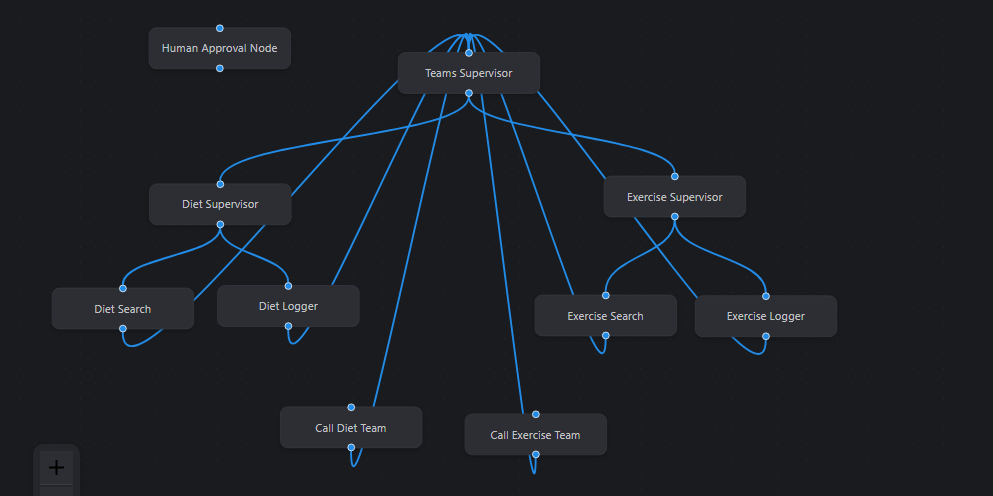

# Successful langsmith trace!!!!!
https://smith.langchain.com/o/468caf91-70e3-4345-8663-a31e215a7073/projects/p/c25726df-41a9-47c0-abcd-dac2cb93f480?timeModel=%7B%22duration%22%3A%227d%22%7D&runtab=0&peek=6c9b8b6f-bd3c-4436-8997-af1059c4ca65

In [ ]:
# TODO https://langchain-ai.github.io/langgraph/concepts/low_level/ try feeding langgraph glossary in separate step while trying to generate the agent architecture
# TODO AAJ modeling is important, it can not be random, needs to follow pregel syntax and we need to convert it to yaml 
# TODO for a particular node, what is the input accessed from state, what is the processing done, i.e. deterministic code/llm
# TODO for llm cases, pre and post processing, what if the llm is with structured output, what if it is binded with tools, what id structured output is bounded with tools
# TODO identify common nodes in other low code agentic frameworks, pick and inject them


In [13]:
# TODO : add a node that converts generated yaml to json. 
# TODO : check regarding human in loop 
# TODO : check how to integrate the replit code with the local langgraph server, includes chat streaming, and code editor and state json and graph view
# TODO : improving graph looks
# TODO : implementing CDJ
# TODO: add nodes that consider human-in-loop, memory, checkpointer etc
# TODO: generated code compilation
# TODO: generated code testing, evaluation, reiteration